In [1]:
import rioxarray as rxr
from glob import glob
import pandas as pd
import shutil
import os
import geopandas as gpd
from rasterstats import zonal_stats
import numpy as np
from tqdm import tqdm
from datetime import datetime
import rasterio
from shapely.geometry import Polygon
import pyproj
import affine
import math
import suncalc
from datetime import datetime
import matplotlib.pyplot as plt
import pytz

from rasterio.errors import NotGeoreferencedWarning
from shapely.errors import ShapelyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [2]:
TIFF_DIR = "data/output/tiff/"
AFFINES_PATH = "data/output/optim_affines.csv"
GEOTIFF_OPTIM_DIR = "data/output/geotiff_optim/"
CRS = "EPSG:32634"
CENTERLINE_PATH = "data/input/shapes/kocinka_centerline.geojson"

In [3]:
images_df = pd.read_csv(AFFINES_PATH)

In [4]:
def raster_footprint(raster):
    footprints = rasterio.features.shapes((raster != raster.rio.nodata).values.astype(np.int16), transform=raster.rio.transform())
    footprints = [Polygon(geom["coordinates"][0]).simplify(10) for geom, colval in footprints if colval == 1]
    assert len(footprints) == 1, "More than one footprint found"
    return footprints[0]
def angle_between(p1, p2):
    p1 = p1.coords[0]
    p2 = p2.coords[0]
    vec = (p2[0] - p1[0], p2[1] - p1[1])
    north_vec = (0, 1)
    #calculate angle between vectors
    dot = vec[0] * north_vec[0] + vec[1] * north_vec[1]
    det = vec[0] * north_vec[1] - vec[1] * north_vec[0]
    angle = math.atan2(det, dot) #in radians
    angle = math.degrees(angle) #in degrees
    angle = angle % 360
    return angle

In [5]:
#open data/centerline.json
centerline = gpd.read_file(CENTERLINE_PATH)
#reproject centerline to 'epsg:32634'
centerline = centerline.to_crs(CRS)
#generate points along centerline every 0.1 meters
distance_delta = 5
distances = np.arange(0, centerline.length[0], distance_delta)
points = [centerline.geometry.interpolate(distance)[0] for distance in distances]
river_pts_gdf = gpd.GeoDataFrame({'geometry': points, 'chainage': distances}, crs=CRS)
#buffer points to 0.1 meters
river_pts_gdf["geometry"] = river_pts_gdf.buffer(0.2)

In [6]:
centerline_points = points
names = []
centroids = []
point_indexes = []
point_azimuths = []
point_altitudes = []
point_distances = []
values = []
sun_azimuths = []
sun_altitudes = []
diff_azimuths = []
chainages = []
cet_times = []
utc_times = []
cet = pytz.timezone("CET")
utc = pytz.timezone("UTC")

for i, row in tqdm(images_df.iterrows(), total=len(images_df)):

    tiff_path = f"{GEOTIFF_OPTIM_DIR}/{row['name']}"
    raster = rxr.open_rasterio(tiff_path, masked=True)
    footprint = raster_footprint(raster)
    centroid = footprint.centroid
    stats = zonal_stats(centerline_points, raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)
    point_indexes_ = [i for i, stat in enumerate(stats) if stat["mean"] != None]
    if point_indexes_ == []:
        continue
    values_ = [stat["mean"] for i, stat in enumerate(stats) if stat["mean"] != None]

    #reproject centroid to 'epsg:4326'
    transformer = pyproj.Transformer.from_crs(CRS, "epsg:4326", always_xy=True)
    lon, lat = transformer.transform(centroid.x, centroid.y)
    time = row["name"].split("_")[1]
    time = datetime.strptime(time, "%Y%m%d%H%M%S")
    cet_time = cet.localize(time)
    utc_time = cet_time.astimezone(utc)
    position = suncalc.get_position(utc_time, lon, lat)
    sun_azimuth = math.degrees(position["azimuth"])
    sun_azimuth = (sun_azimuth + 180) % 360
    sun_altitude = math.degrees(position["altitude"])
    reflected_vactor = 
    point_azimuths_ = []
    point_distances_ = []
    point_altitudes_ = []
    diff_azimuths_ = []
    for idx in point_indexes_:
        point_azimuth = angle_between(centroid, centerline_points[idx])
        point_distance = centerline_points[idx].distance(centroid)
        point_altitude = math.atan2(50., point_distance)
        point_altitudes_.append(point_altitude)
        point_azimuths_.append(point_azimuth)
        point_distances_.append(point_distance)
        diff_azimuths_.append(point_azimuth - sun_azimuth)
    sun_azimuths.append(sun_azimuth)
    sun_altitudes.append(sun_altitude)
    cet_times.append(cet_time)
    utc_times.append(utc_time)
    point_azimuths.append(point_azimuths_)
    point_distances.append(point_distances_)
    point_altitudes.append(point_altitudes_)
    centroids.append(centroid)
    point_indexes.append(point_indexes_)
    values.append(values_)
    diff_azimuths.append(diff_azimuths_)
    chainages.append([centerline_points[idx].distance(centerline_points[0]) for idx in point_indexes_])
    names.append(row['name'])

100%|██████████| 453/453 [02:39<00:00,  2.85it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

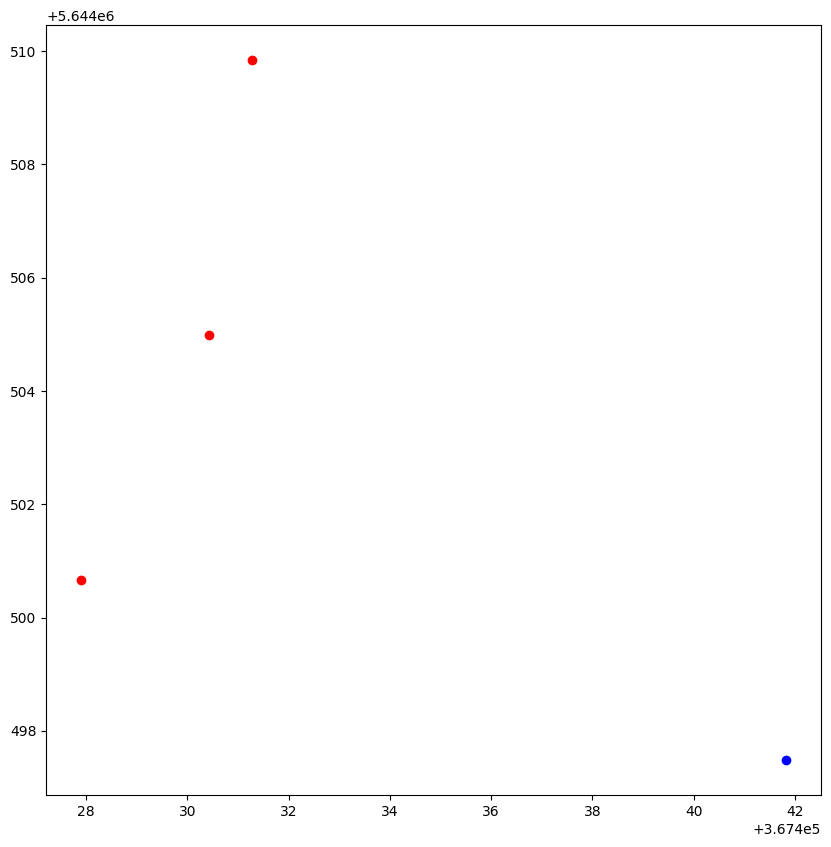

In [14]:
#plot centerline_points_1 and centroids[1]
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter([point.x for point in centerline_points_1], [point.y for point in centerline_points_1], color="red")
plt.scatter(centroids[1].x, centroids[1].y, color="blue")
plt.show

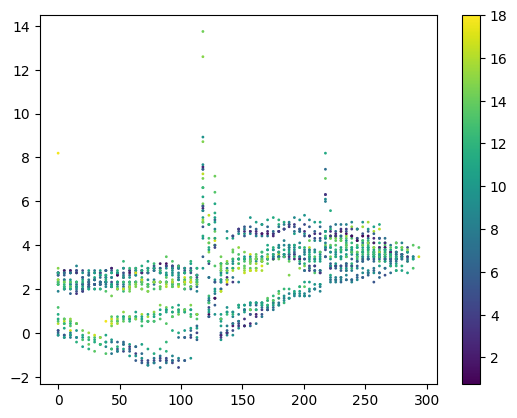

In [11]:
x = []
y = []
z = []
for val_row, chainage_row, diff_azimuth_row in zip(values, chainages, point_distances):
    for val, chainage, diff_azimuth in zip(val_row, chainage_row, diff_azimuth_row):
        x.append(chainage)
        y.append(val)
        z.append(diff_azimuth % 360)
#plot scatter
plt.scatter(x, y, c=z, cmap='viridis', s=1)
#colorbar
plt.colorbar()

plt.show()